## Imports

In [1]:
import pandas as pd
from sqlalchemy import create_engine, text
import getpass

## SQL Setup

In [2]:
pw = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + pw + '@localhost:3306/'
engine = create_engine(connection_string)

········


## Data import and exploration

In [3]:
df_credits = pd.read_csv("data/credits.csv")
df_keywords = pd.read_csv("data/keywords.csv")
df_links = pd.read_csv("data/links.csv")
df_ratings = pd.read_csv("data/ratings.csv")
df_metadata = pd.read_csv("data/movies_metadata.csv")

/var/folders/wx/v19kf4_j1p1gwtlfg83w0_gm0000gn/T/ipykernel_97399/2530930740.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_metadata = pd.read_csv("data/movies_metadata.csv")


In [4]:
print(f"movielens_credits: {df_credits.shape}")
print(f"movielens_links: {df_keywords.shape}")
print(f"movielens_keywords: {df_links.shape}")
print(f"movielens_ratings: {df_ratings.shape}")
print(f"movielens_metadata: {df_metadata.shape}")

movielens_credits: (45476, 3)
movielens_links: (46419, 2)
movielens_keywords: (45843, 3)
movielens_ratings: (26024289, 4)
movielens_metadata: (45466, 24)


# Data parsing

In [5]:
from ast import literal_eval
df_credits['cast'] = df_credits['cast'].apply(literal_eval)
df_credits['crew'] = df_credits['crew'].apply(literal_eval)
df_keywords['keywords'] = df_keywords['keywords'].apply(literal_eval)

### Extracting keywords ids

In [6]:
def transform_keyword_dict(l, id_key = 'id', name_keyy = 'name'):
    dict_res = dict()
    for d in l:
        dict_res[d[id_key]] = d[name_keyy]
    return dict_res

def merge_dict_serie_and_assert_consistency(serie, fail_on_inconsistency = True):
    compond_dict = dict()
    for d in serie.values:
         for k,v in d.items():
            if k in compond_dict.keys():
                if not compond_dict[k] == v:
                    if fail_on_inconsistency:
                        raise Exception(f"Name inconsistency {v}, {compond_dict[k]}")
                    else:
                        print(f"Inconsistency on id {k} : names : {v} /  {compond_dict[k]}")
            compond_dict.update(d)
    return compond_dict

def extract_id_name_dict(serie, fail_on_inconsistency = True, id_key = 'id'):
    parsed_serie = serie.apply(transform_keyword_dict, id_key = id_key)
    return merge_dict_serie_and_assert_consistency(parsed_serie, fail_on_inconsistency = fail_on_inconsistency)

def extract_keyword_ids(l, id_key = 'id'):
    return {d[id_key] for d in l }

def is_na(x):
    return x != x or x is None

def str_join(iterable, sep = ','):
    if is_na(iterable):
        return ''
    if isinstance(iterable, str) or isinstance(iterable, int):
        return str(iterable) 
    return sep.join(str(i) for i in iterable)


all_keywords_dict = extract_id_name_dict(df_keywords['keywords'])
df_keyword_table = pd.DataFrame({'keyword' : all_keywords_dict}).reset_index()

df_keywords['keywords'] = df_keywords['keywords'].apply(extract_keyword_ids)
df_keywords['keywords'] = df_keywords['keywords'].apply(str_join)
print(f"There are {len(all_keywords_dict.keys())} different keywords")

There are 19956 different keywords


### Extracting the people ids

In [7]:
people_serie = pd.concat([df_credits['cast'], df_credits['crew']], ignore_index = True)
people_details = extract_id_name_dict(people_serie, fail_on_inconsistency= False)
df_people = pd.DataFrame({'cast' : people_details}).reset_index()

for col in ['cast', 'crew']:
    df_credits[col] = df_credits[col].apply(extract_keyword_ids)
    df_credits[col] = df_credits[col].apply(str_join)

Inconsistency on id 99692 : names : Liao Fan /  廖凡
Inconsistency on id 111690 : names : Takako Matsu /  松隆子
Inconsistency on id 117642 : names : Jason Momoa /  杰森·莫玛
Inconsistency on id 9779 : names : Morris Chestnut /  Моррис Честнат
Inconsistency on id 23764 : names : Erika Eleniak /  Эрика Элениак
Inconsistency on id 9779 : names : Моррис Честнат /  Morris Chestnut
Inconsistency on id 117642 : names : 杰森·莫玛 /  Jason Momoa


### Meta data parsing of Genre, Collections, Languages and Companies

In [8]:
def literal_eval_if_not_na(x, default_value = pd.NA):
    if is_na(x):
        return default_value
    else:
        return literal_eval(x)

METADATA_COLUMNS_TO_PARSE = ['belongs_to_collection', 'genres', 'spoken_languages', 'production_companies', 'production_countries']
for col in METADATA_COLUMNS_TO_PARSE:
    filter_not_na = df_metadata[col].notnull()
    df_metadata.loc[filter_not_na, col] = df_metadata[filter_not_na][col].apply(literal_eval)

#fixing odd values
filter_wierd_values = (df_metadata['production_companies'] == False)
df_metadata = df_metadata[~filter_wierd_values].copy()

# Generating mappings for 'belongs_to_collection', 'genres', 'production_companies'
filter_not_na = df_metadata['production_companies'].notnull()
production_companies_dict = extract_id_name_dict(df_metadata[filter_not_na]['production_companies'], fail_on_inconsistency= False)
df_production_companies = pd.DataFrame({'company' : production_companies_dict}).reset_index()
df_metadata.loc[filter_not_na, 'production_companies'] = df_metadata[filter_not_na]['production_companies'].apply(extract_keyword_ids)


filter_not_na = df_metadata['belongs_to_collection'].notnull()
parsed_serie = df_metadata[filter_not_na]['belongs_to_collection'].apply(lambda d : {d['id'] : d['name']})
collection_dict = merge_dict_serie_and_assert_consistency(parsed_serie, fail_on_inconsistency = True)
df_collection = pd.DataFrame({'collection' : collection_dict}).reset_index()
df_metadata.loc[filter_not_na, 'belongs_to_collection'] = df_metadata[filter_not_na]['belongs_to_collection'].apply(lambda x: x['id'])

genre_serie = df_metadata['genres']
genres_dict = extract_id_name_dict(genre_serie, fail_on_inconsistency= True)
df_genres = pd.DataFrame({'genres' : genres_dict}).reset_index()
df_metadata['genres'] = df_metadata['genres'].apply(extract_keyword_ids)

filter_not_na = df_metadata['spoken_languages'].notnull()
language_serie = df_metadata[filter_not_na]['spoken_languages'].apply(extract_keyword_ids, id_key = 'iso_639_1')
df_metadata.loc[filter_not_na, 'spoken_languages'] = language_serie

filter_not_na = df_metadata['production_countries'].notnull()
df_metadata.loc[filter_not_na, 'production_countries'] = df_metadata[filter_not_na]['production_countries'].apply(extract_keyword_ids, id_key = 'iso_3166_1')


for col in METADATA_COLUMNS_TO_PARSE:
    df_metadata[col] = df_metadata[col].apply(str_join)


### Aggregating Ratings stats

In [9]:
aggregator_list = ['mean', 'std', 'max', 'min', 'count']
df_rating_stats = df_ratings.groupby('movieId').agg({'rating' : aggregator_list})
df_rating_stats.columns = aggregator_list
df_rating_stats['std'] = df_rating_stats['std'].fillna(0)
df_rating_stats = df_rating_stats.reset_index().sort_values('count', ascending=False)

### Cleaning missing/dupliacted values

In [10]:
df_links = df_links.dropna(how = 'any')
df_links = df_links.drop_duplicates('tmdbId')
df_credits = df_credits.drop_duplicates('id')
df_keywords = df_keywords.drop_duplicates('id')
df_metadata = df_metadata.drop_duplicates('id')
df_metadata = df_metadata[df_metadata.status == 'Released'].copy()

### Visualization

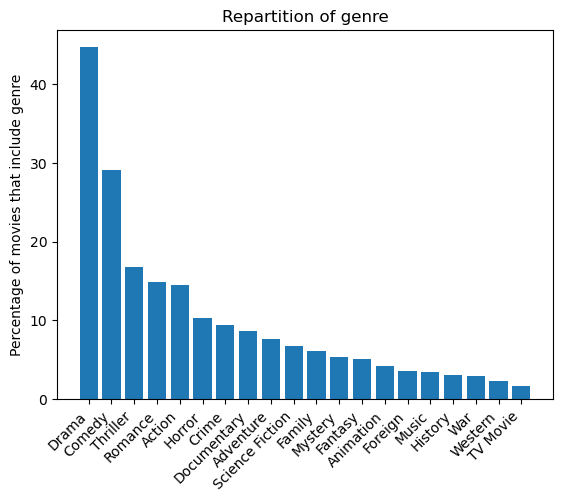

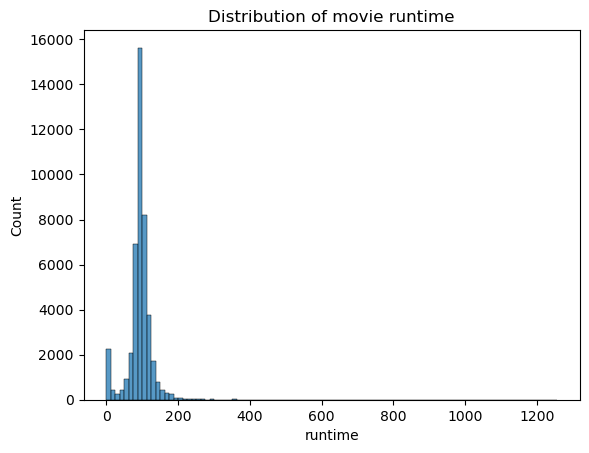

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter

genre_occurence = Counter(sum(genre_serie.apply(lambda x : [i['name'] for i in x]).values, start = []))


genre = []
percentage = []
for k,v in genre_occurence.items():
    genre.append(k)
    percentage.append(100*v / genre_serie.shape[0])
percentage, genre = zip(*sorted(zip(percentage, genre), reverse = True))

plt.bar(genre, percentage)
_ = plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage of movies that include genre')
plt.title('Repartition of genre')
plt.show()


sns.histplot(df_metadata['runtime'], bins= 100)
plt.title('Distribution of movie runtime')
plt.show()

In [12]:
df_metadata['runtime'].median()

95.0

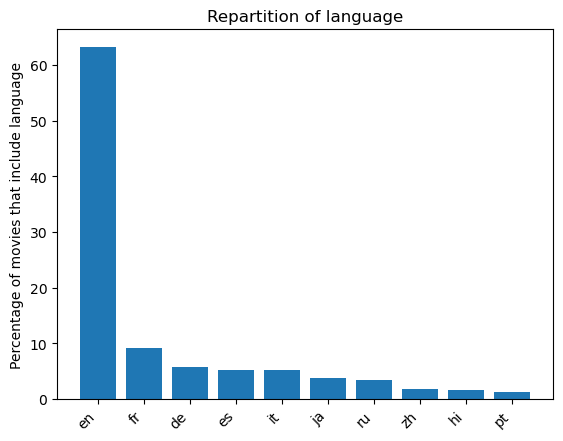

In [13]:
from collections import Counter
from matplotlib import pyplot as plt
NUMBER_TO_DISPLAY = 10
genre_occurence = Counter(sum(language_serie.apply(list).values, start = []))

language = []
percentage = []
for k,v in genre_occurence.items():
    language.append(k)
    percentage.append(100*v / language_serie.shape[0])
percentage, language = zip(*sorted(zip(percentage, language), reverse = True))

plt.bar(language[:NUMBER_TO_DISPLAY], percentage[:NUMBER_TO_DISPLAY])
_ = plt.xticks(rotation=45, ha='right')

plt.ylabel('Percentage of movies that include language')
plt.title('Repartition of language')
plt.show()


### Uploading all Data to SQL

In [14]:
# Put the data in a clean string for storage :


import time
def upload_to_sql(dataframe, table_name, engine, verbose = True):
    if verbose:
        print(f"Uploading table '{table_name}'...", end = '')
        start = time.time()
    dataframe.to_sql(table_name, engine, 'movielens', if_exists = 'replace', index=False)
    if verbose:
        duration = time.time()-start
        print(f' Completed in {round(duration,1)}s.')


upload_to_sql(df_credits, 'credits', engine)
upload_to_sql(df_metadata, 'metadata', engine)
upload_to_sql(df_links, 'links', engine)
upload_to_sql(df_rating_stats, 'ratings', engine)
upload_to_sql(df_keywords, 'keywords', engine)


#Only usefull to print some information to the user
if False:
    upload_to_sql(df_people, 'people', engine)
    upload_to_sql(df_genres, 'genres', engine)
    upload_to_sql(df_collection, 'collections', engine)
    upload_to_sql(df_production_companies, 'companies', engine)

Uploading table 'credits'... Completed in 3.7s.
Uploading table 'metadata'... Completed in 8.5s.
Uploading table 'links'... Completed in 1.9s.
Uploading table 'ratings'... Completed in 2.2s.
Uploading table 'keywords'... Completed in 1.3s.


# Data Preparation

In [15]:
columns = ["links.movieId", "imdbId", "tmdbId", "cast", "crew", "keywords", "mean", "count", "adult", "belongs_to_collection", "budget", "genres", "homepage", "original_language", "original_title", "overview", "popularity", "poster_path", "production_companies", "production_countries", "release_date", "revenue", "runtime", "spoken_languages", "status", "tagline", "title", "video", "vote_average", "vote_count"]
query = f"""SELECT {', '.join(columns)}
FROM credits 
	INNER JOIN 
    keywords 
    ON credits.id = keywords.id 
    INNER JOIN links
    ON credits.id = links.tmdbId
    INNER JOIN ratings 
    ON links.movieId = ratings.movieId
    INNER JOIN metadata
    ON credits.id  = metadata.id"""

with engine.connect() as conn:
    conn.execute(text("USE movielens"))
    res = conn.execute(text(query))
    data = res.fetchall()
df_data = pd.DataFrame(data).rename(columns = {'mean' : 'mean_score'})
df_data.shape

for col in ['movieId', 'imdbId', 'tmdbId']:
    assert not df_data[col].duplicated().any()


In [16]:
# Take the string representation of list and put them back as a list
columns_to_one_hot = ['cast', 'crew', 'keywords'] + METADATA_COLUMNS_TO_PARSE
for col in columns_to_one_hot:
    df_data[col] = df_data[col].fillna('').apply(str.split, sep = ',')

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from scipy.sparse import hstack

def encode(df_selected_columns):
    mlb = MultiLabelBinarizer(sparse_output=True)
    columns_to_mlb = ["keywords", "belongs_to_collection", "genres"]
    sparse_matrixes = []
    for col in columns_to_mlb:
        sparse_matrixes.append(mlb.fit_transform(df_selected_columns[col]))

    ohe = OneHotEncoder(handle_unknown='ignore')
    ohe.fit(df_selected_columns[df_selected_columns["original_language"].notnull()]["original_language"].unique().reshape(-1,1))
    sparse_matrixes.append(ohe.transform(df_selected_columns["original_language"].fillna('').values.reshape(-1,1)))
    return hstack(tuple(sparse_matrixes))

total_one_hot_encoded = encode(df_data)
df_data['released_year'] = pd.to_datetime(df_data.release_date).dt.year

In [18]:
from sklearn.cluster import KMeans

kmean = KMeans()
clustered_movies = kmean.fit_predict(total_one_hot_encoded)
df_data['cluster_number'] =  clustered_movies

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

for cluster_number in range(8):
    filter_cluster = df_data['cluster_number'] == cluster_number
    df_filtered = df_data[filter_cluster]
    id_dict = df_filtered.movieId.to_dict()

    # Encodage 'One hot'
    partial_one_hot_encoded = encode(df_filtered)
    
    # Calcul de similarité
    r = cosine_similarity(partial_one_hot_encoded)

    from tqdm import tqdm 
    NB_RECOMMENDATION = 10
    recomended_id_list = []
    for i in tqdm(range(r.shape[0])):
        l = sorted(list(range(r.shape[1])),key = lambda x : r[i][x], reverse = True)[1:1+NB_RECOMMENDATION]
        recomended_id_list.append([id_dict[df_filtered.index[i]] for i in l])
    
    recomended_serie = pd.Series(recomended_id_list)
    recomended_serie.index = df_data[filter_cluster].index
    df_data.loc[filter_cluster, 'recommendation_id'] = recomended_serie

100%|██████████████████████████████████████| 5763/5763 [00:25<00:00, 229.86it/s]


In [20]:
id_title_dict = df_data.set_index('movieId')['title'].to_dict()

df_data['recommendation_title'] = df_data['recommendation_id'].apply(lambda x: [id_title_dict[i] for i in x])

In [21]:
df_data[df_data.title.apply(lambda x : 'fast and' in x.lower())].columns

Index(['movieId', 'imdbId', 'tmdbId', 'cast', 'crew', 'keywords', 'mean_score',
       'count', 'adult', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'released_year', 'cluster_number',
       'recommendation_id', 'recommendation_title'],
      dtype='object')

In [22]:
def print_details(df_data, film):
    df_short = df_data[df_data.title == film].head(1)
    print('Language :', df_short.original_language.values[0])
    print('Genres :', ' / '.join(sorted([genres_dict[int(i)] for i in df_short.genres.values[0]])))
    print('Keywords :', ' / '.join(sorted([all_keywords_dict[int(i)] for i in df_short.keywords.values[0] if len(i) > 0])))

    
def get_recommandations(df_data, film):
    df_short = df_data[df_data.title == film]
    return df_short.recommendation_title.values[0]
    
film = input('Choose a movie : ')

print_details(df_data, film)
print('')
reco = get_recommandations(df_data, film)
for i, other_film in enumerate(reco):
    print(i+1, ':', other_film)
    print_details(df_data, other_film)
    print('')
    

Choose a movie : Avatar
Language : en
Genres : Action / Adventure / Fantasy / Science Fiction
Keywords : 3d / alien / alien planet / anti war / battle / cgi / culture clash / future / futuristic / love affair / marine / mind and soul / power relations / romance / society / soldier / space / space colony / space travel / space war / tribe

1 : Jupiter Ascending
Language : en
Genres : Action / Adventure / Fantasy / Science Fiction
Keywords : 3d / interspecies romance / jupiter / space / woman director

2 : Star Trek Into Darkness
Language : en
Genres : Action / Adventure / Science Fiction
Keywords : 3d / alien / friendship / futuristic / imax / sequel / space / space opera / spacecraft / terrorist bombing

3 : Transmorphers
Language : en
Genres : Action / Adventure / Science Fiction
Keywords : futuristic

4 : Hawk the Slayer
Language : en
Genres : Action / Adventure / Fantasy / Science Fiction
Keywords : 

5 : 20,000 Leagues Under the Sea
Language : en
Genres : Action / Adventure / Scien

# Some graphs

<AxesSubplot: xlabel='released_year', ylabel='Count'>

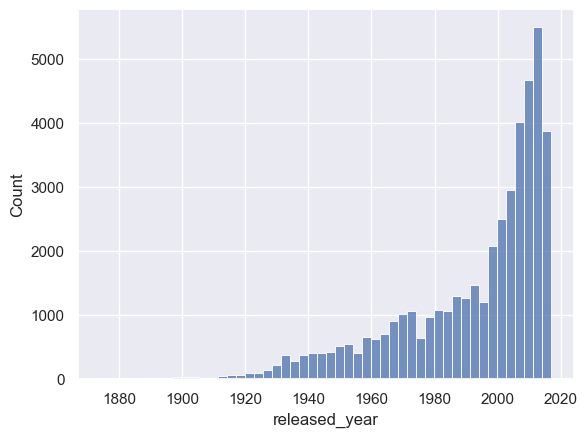

In [23]:
import seaborn as sns
sns.set_theme()
#sns.set_theme(palette="light:#5A9")
sns.histplot(df_data['released_year'], bins= 50)

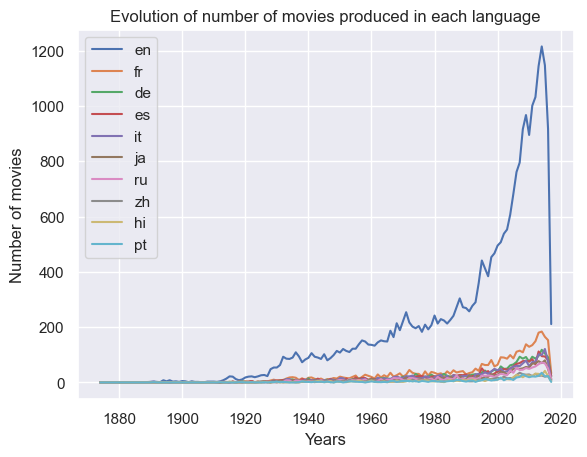

In [24]:
def agg_func(x):
    return Counter(sum(x, start = []))

df_data['released_year'] = pd.to_datetime(df_metadata.release_date).dt.year
df_by_year = df_data.groupby('released_year').agg({'spoken_languages' : agg_func, 'genres' : agg_func, 'revenue' : 'mean', 'vote_average' : 'mean'})

for l in language[:NUMBER_TO_DISPLAY]:
    occurences = df_by_year.spoken_languages.apply(lambda x: x[l])
    proportion = df_by_year.spoken_languages.apply(lambda x: x[l]/sum(x.values()))
    plt.plot(df_by_year.index, occurences, label = l)

plt.ylabel("Number of movies")
plt.xlabel("Years")
plt.title('Evolution of number of movies produced in each language')
plt.legend()
plt.show()

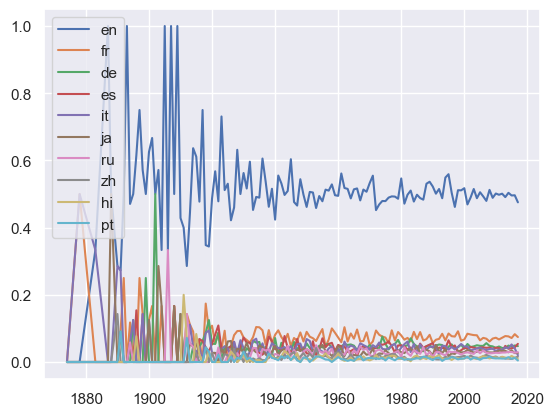

In [25]:
for l in language[:NUMBER_TO_DISPLAY]:
    occurences = df_by_year.spoken_languages.apply(lambda x: x[l])
    proportion = df_by_year.spoken_languages.apply(lambda x: x[l]/sum(x.values()))
    plt.plot(df_by_year.index, proportion, label = l)

plt.legend()

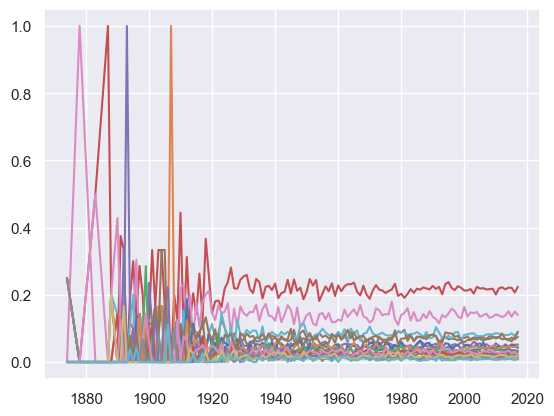

In [26]:
for l, display in df_genres.set_index('index').genres.to_dict().items():
    occurences = df_by_year.genres.apply(lambda x: x[l])
    proportion = df_by_year.genres.apply(lambda x: x[str(l)]/sum(x.values()))
    plt.plot(df_by_year.index, proportion, label = display)

#plt.legend()

In [27]:
df_by_year.genres.values[-1]

Counter({'35': 97,
         '99': 33,
         '18': 155,
         '10749': 61,
         '878': 20,
         '9648': 14,
         '27': 36,
         '53': 63,
         '28': 52,
         '10769': 12,
         '12': 23,
         '36': 7,
         '': 19,
         '10402': 13,
         '16': 7,
         '80': 29,
         '37': 10,
         '10751': 13,
         '10752': 11,
         '14': 11,
         '10770': 6})

In [28]:
pd.to_datetime(df_data['release_date']).max()

Timestamp('2017-12-27 00:00:00')

In [29]:
pd.to_datetime(df_data['release_date']).min()

Timestamp('1874-12-09 00:00:00')